In [1]:
import pickle
import matplotlib.pyplot as plt
import torch
import numpy as np
from src.Dataset_loader import CustomImageDataset
import matplotlib.pyplot as plt

def show(img):
    img = img/255
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)), interpolation='nearest')
    plt.show()
    
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
torch.__version__

'2.3.1+cu121'

In [3]:
CIFAR10_train_dataset = CustomImageDataset()
CIFAR10_test_dataset = CustomImageDataset()
CIFAR10_train_dataset.load_batch('data/cifar-10-batches-py/data_batch_1')
CIFAR10_train_dataset.load_batch('data/cifar-10-batches-py/data_batch_2')
CIFAR10_train_dataset.load_batch('data/cifar-10-batches-py/data_batch_3')
CIFAR10_train_dataset.load_batch('data/cifar-10-batches-py/data_batch_4')
CIFAR10_train_dataset.load_batch('data/cifar-10-batches-py/data_batch_5')

CIFAR10_test_dataset.load_batch('data/cifar-10-batches-py/test_batch')

train_loader = torch.utils.data.DataLoader(CIFAR10_train_dataset, batch_size=32,
                                         shuffle=False, pin_memory=True)

test_loader = torch.utils.data.DataLoader(CIFAR10_test_dataset, batch_size=32,
                                         shuffle=False, pin_memory=True)

In [4]:
from src.models import Net
net = Net()

In [5]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
epochs = np.arange(1, 11)
losses_train = list()
losses_test = list()
for epoch in epochs:  # loop over the dataset multiple times
    epoch_loss_train = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        epoch_loss_train += loss.item()
        if i % 500 == 499:    # Print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0
    epoch_loss_test = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            epoch_loss_test += loss.item()
    losses_train.append(epoch_loss_train/len(train_loader))
    losses_test.append(epoch_loss_test/len(test_loader))
    

print('Finished Training')


[2,   500] loss: 2.192
[2,  1000] loss: 1.936
[2,  1500] loss: 1.762
[3,   500] loss: 1.677
[3,  1000] loss: 1.593
[3,  1500] loss: 1.560
[4,   500] loss: 1.517
[4,  1000] loss: 1.457
[4,  1500] loss: 1.462
[5,   500] loss: 1.433
[5,  1000] loss: 1.379
[5,  1500] loss: 1.405
[6,   500] loss: 1.367
[6,  1000] loss: 1.323
[6,  1500] loss: 1.349
[7,   500] loss: 1.310
[7,  1000] loss: 1.283
[7,  1500] loss: 1.306
[8,   500] loss: 1.269
[8,  1000] loss: 1.232
[8,  1500] loss: 1.258
[9,   500] loss: 1.227
[9,  1000] loss: 1.206
[9,  1500] loss: 1.240
[10,   500] loss: 1.222
[10,  1000] loss: 1.190
[10,  1500] loss: 1.240
[11,   500] loss: 1.203
[11,  1000] loss: 1.173
[11,  1500] loss: 1.211
Finished Training


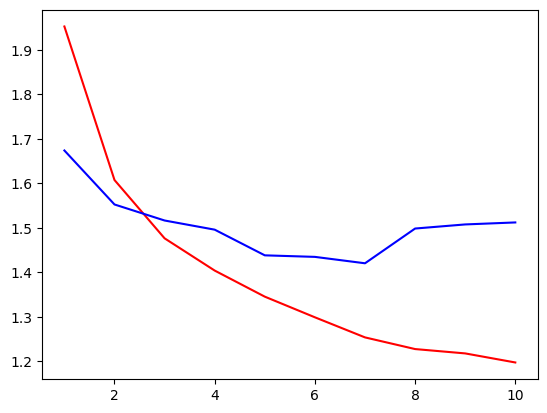

In [13]:
plt.plot(epochs, losses_train, color='r')
plt.plot(epochs, losses_test, color='b');

In [15]:
epochs = np.append(epochs, np.arange(12, 25))
for epoch in np.arange(12, 25):  # loop over the dataset multiple times
    epoch_loss_train = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        epoch_loss_train += loss.item()
        if i % 500 == 499:    # Print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0
    epoch_loss_test = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            epoch_loss_test += loss.item()
    losses_train.append(epoch_loss_train/len(train_loader))
    losses_test.append(epoch_loss_test/len(test_loader))
    

print('Finished Training')

[13,   500] loss: 1.203
[13,  1000] loss: 1.153
[13,  1500] loss: 1.177
[14,   500] loss: 1.170
[14,  1000] loss: 1.111
[14,  1500] loss: 1.158
[15,   500] loss: 1.138
[15,  1000] loss: 1.093
[15,  1500] loss: 1.154
[16,   500] loss: 1.112
[16,  1000] loss: 1.089
[16,  1500] loss: 1.154
[17,   500] loss: 1.106
[17,  1000] loss: 1.098
[17,  1500] loss: 1.150
[18,   500] loss: 1.129
[18,  1000] loss: 1.120
[18,  1500] loss: 1.113
[19,   500] loss: 1.117
[19,  1000] loss: 1.111
[19,  1500] loss: 1.116
[20,   500] loss: 1.117
[20,  1000] loss: 1.066
[20,  1500] loss: 1.055
[21,   500] loss: 1.117
[21,  1000] loss: 1.049
[21,  1500] loss: 1.041
[22,   500] loss: 1.085
[22,  1000] loss: 1.051
[22,  1500] loss: 1.080
[23,   500] loss: 1.078
[23,  1000] loss: 1.051
[23,  1500] loss: 1.055
[24,   500] loss: 1.064
[24,  1000] loss: 1.034
[24,  1500] loss: 1.064
[25,   500] loss: 1.061
[25,  1000] loss: 1.050
[25,  1500] loss: 1.066
Finished Training


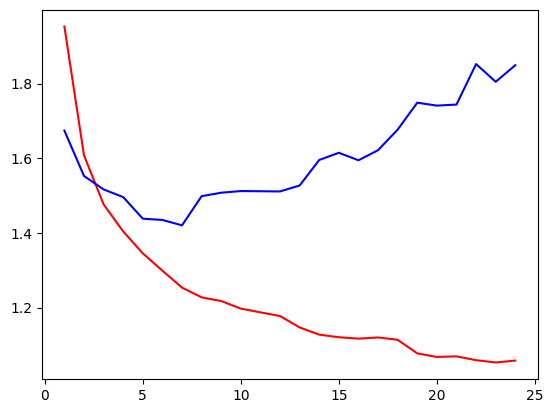

In [16]:
plt.plot(epochs, losses_train, color='r')
plt.plot(epochs, losses_test, color='b');

In [11]:
epoch_loss = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        

print(f'Loss of the network on test images: {epoch_loss/len(test_loader):.3f}')


Loss of the network on test images: 3.328
